В этой тетрадке мы рассмотрим задачу распознавания лиц на примере датасета [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)



In [189]:
import numpy as np

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision.models import resnet34


In [190]:
from tqdm.auto import tqdm

## Data


Структура архива:
- /celeba_data/
    - train.csv
    - val.csv
    - images/{image}.jpg

CSV файлы содержат название файла (`image`) и его лейбл (`label`).

In [193]:
from cloud_ml.storage.api import Storage

s3 = Storage.s3(access_key="***", secret_key="***")
# downloading contents of the remote file into the local one
s3.get('dl-hse-2021/celeba_data.zip', './celeba_data.zip')

In [194]:
#!:bash
unzip -q ./celeba_data.zip -d ./ && rm celeba_data.zip

Класс датасет, который будет возвращать картинку и ее лейбл.

In [195]:
import os
import cv2
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [537]:
class CelebADataset(Dataset):
    def __init__(self, train = True):
        super().__init__()
        if train == True:
            self.data = pd.read_csv('celeba_data/train.csv')
            
        else:
            self.data = pd.read_csv('celeba_data/val.csv')
        
        self.root_dir = 'celeba_data/images'
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #Read image
        img = os.path.join(self.root_dir, self.data.iloc[index, 0])
        img = cv2.imread(img)
        #Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img).astype(np.float32) /255
#         img = img[None, ...]
        #HWC -> CHW
        img = torch.tensor(img)
        img = img.permute(2,0,1)
        img = np.array(img).astype(np.float32)
#         img = to
        label = self.data.iloc[index, 1]
        sample = {'sample': img, 'label': label}
        return sample

In [198]:
def train_dataset():
    train = CelebADataset(train = True)
    return train

In [199]:
def val_dataset():
    val = CelebADataset(train = False)
    return val

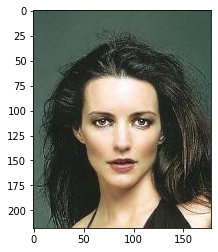

In [517]:
img = cv2.imread('celeba_data/images/000035.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Top-n accuracy.

$$TopN \ Accuracy = \frac{Number \ of \ objects \ with \ correct \ answer \ among \ topN \ predictions}{Total \ number \ of \ objects}$$

*Example:*

![image](https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-ae746981c7a437b7e1fc2831e5d76d57_l3.svg)  
$Top3 \ Accuracy = \frac{4}{5} = 0.8$



In [506]:
def top_n_accuracy(preds: np.ndarray,
                   targets: np.ndarray,
                   n_size: int) -> float:
    preds = preds[:,:n_size]
    num_of_correct = 0
    total_num = len(targets)
    for i in range(0,len(targets)):
        if targets[i] in preds[i]:
            num_of_correct+=1
    topNaccuracy = num_of_correct/total_num
    return topNaccuracy

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


Используется предобученная сетка (`backbone`), которая выдает эмбеддинги. 

Задача: сложить эмбеддинги в массив, для каждого вектора найти ближайшие, отсортировать их по расстоянию. Метки соседей будут предсказаниями для текущего вектора.

In [912]:
#!L
backbone = resnet34(pretrained=True)
backbone.fc = nn.Identity()
backbone = backbone.eval()

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [ ]:
pred_len = 19867

In [931]:
#!L
from sklearn.metrics.pairwise import cosine_similarity
def evaluation(batch_size):
    preds = np.zeros((pred_len, 512))
    true_labels = np.zeros((pred_len))
    val_set = val_dataset()
    val_loader = DataLoader(val_set, shuffle = False, pin_memory = True, batch_size = batch_size)
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = backbone.to(device)
    with torch.no_grad():
        i = 0
        for batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
#             print(i)
            x = batch['sample']
            y = batch['label']
            out = backbone(x)
            if i == 155:
                preds[i:i+(pred_len - int(pred_len/batch_size)*batch_size), :] = out.cpu().numpy()
                true_labels[i:i+(pred_len - int(pred_len/batch_size)*batch_size)] = y.cpu().numpy()
            else:
                preds[i:i+batch_size, :] = out.cpu().numpy()
                true_labels[i:i+batch_size] = y.cpu().numpy()
            i +=batch_size
    #calc cosine and leave top5
    neighbours = cosine_similarity(preds)
    np.fill_diagonal(neighbours, 0)
    
    
    neighbours = neighbours.argsort()[:,::-1]
    neighbours = neighbours[:,:25]
    
    top5_preds = np.zeros((neighbours.shape))
    for i in range(0,len(true_labels)):
        top5_preds[i][:len(list(dict.fromkeys(true_labels[neighbours[i]])))] = list(dict.fromkeys(true_labels[neighbours[i]]))
    top5_preds = top5_preds[:,:5]
    #top1 accuracy
    top1_accuracy = top_n_accuracy(top5_preds, true_labels, 1)
    #top5 accuracy
    top5_accuracy = top_n_accuracy(top5_preds, true_labels, 5)
    return top5_preds, top1_accuracy, top5_accuracy, preds, true_labels

top5_preds, top1_accuracy, top5_accuracy, val_embeddings, val_true_labels = evaluation(128)

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [932]:
top1_accuracy, top5_accuracy

(0.17098706397543664, 0.2886696531937384)